In [6]:
import torch
import transformers
import zarr
from src.models.utils import no_grad
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


import numpy as np
from tqdm import tqdm
import os
from pathlib import Path


device = "cuda:1"

data_base_path = Path(os.environ["FURNITURE_DATA_DIR"])

In [2]:
enc = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14").eval().to(device)

for param in enc.parameters():
    param.requires_grad = False

enc.num_features

Using cache found in /home/larsankile/.cache/torch/hub/facebookresearch_dinov2_main
/home/larsankile/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/larsankile/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/larsankile/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


768

In [3]:
# Check how many out features the model has
print(enc.num_features)

768


In [4]:
trans = transformers.AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = transformers.AutoModel.from_pretrained("facebook/dinov2-base").eval().to(device)
no_grad(model)

In [5]:
model.config.hidden_size

768

In [9]:
data_base_path

PosixPath('/data/pulkitag/data/ankile/furniture-data/data')

In [29]:
d_sim = zarr.open(data_base_path / "processed/sim/image/one_leg/low/data.zarr")
d_real = zarr.open(data_base_path / "processed/real/image/one_leg/low/data.zarr")

In [30]:
data_base_path / "processed/real/image/one_leg/low/data.zarr"

PosixPath('/data/pulkitag/data/ankile/furniture-data/data/processed/real/image/one_leg/low/data.zarr')

In [31]:
d_sim["color_image1"].shape, d_real["color_image2"].shape

KeyError: 'color_image2'

(-0.5, 223.5, 223.5, -0.5)

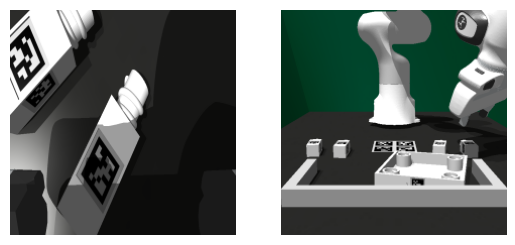

In [32]:
# show an image
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(d_sim["color_image1"][120])
ax2.imshow(d_sim["color_image2"][120])

# Turn off axis
ax1.axis("off")
ax2.axis("off")

In [18]:
def get_embeddings(image_list, model, batch_size=256):
    n = len(image_list)
    embeddings = np.zeros((n, 768))

    for i in tqdm(range(0, n, batch_size)):
        batch = image_list[i : i + batch_size]
        batch = np.array(batch)

        # Assuming the model expects input shape [batch_size, 3, 224, 224]
        batch = np.transpose(batch, (0, 3, 1, 2))

        # Convert to torch tensor and forward pass
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        with torch.no_grad():
            emb_batch = model(batch_tensor).pooler_output.detach().cpu().numpy()

        embeddings[i : i + batch_size] = emb_batch

    return embeddings

In [19]:
def sample_n_rows(arr, n):
    idx = np.random.choice(arr.shape[0], n, replace=False)
    return arr[idx]

In [11]:
# Get embeddings for a random sample of 1000 images
emb_sim_1 = get_embeddings(sample_n_rows(d_sim["image1"], 1000), model)
emb_sim_2 = get_embeddings(sample_n_rows(d_sim["image2"], 1000), model)
emb_real_1 = get_embeddings(sample_n_rows(d_real["image1"], 1000), model)
emb_real_2 = get_embeddings(sample_n_rows(d_real["image2"], 1000), model)

100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


In [20]:
def plot_latent_space(reduction, emb_sim_1, emb_sim_2, emb_real_1, emb_real_2):
    reduced_1 = reduction.fit_transform(np.concatenate([emb_sim_1, emb_real_1]))
    reduced_2 = reduction.fit_transform(np.concatenate([emb_sim_2, emb_real_2]))

    red_sim_1 = reduced_1[:1000]
    red_real_1 = reduced_1[1000:]
    red_sim_2 = reduced_2[:1000]
    red_real_2 = reduced_2[1000:]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.scatter(red_sim_1[:, 0], red_sim_1[:, 1], label="sim_1", alpha=0.5)
    ax1.scatter(red_real_1[:, 0], red_real_1[:, 1], label="real_1", alpha=0.5)
    ax1.set_title("Wrist camera")
    ax1.legend(frameon=False)

    ax2.scatter(red_sim_2[:, 0], red_sim_2[:, 1], label="sim_2", alpha=0.5)
    ax2.scatter(red_real_2[:, 0], red_real_2[:, 1], label="real_2", alpha=0.5)
    ax2.set_title("Front camera")
    ax2.legend(frameon=False)

    fig.suptitle(f"{reduction.__class__.__name__} reduction of DINO embeddings")

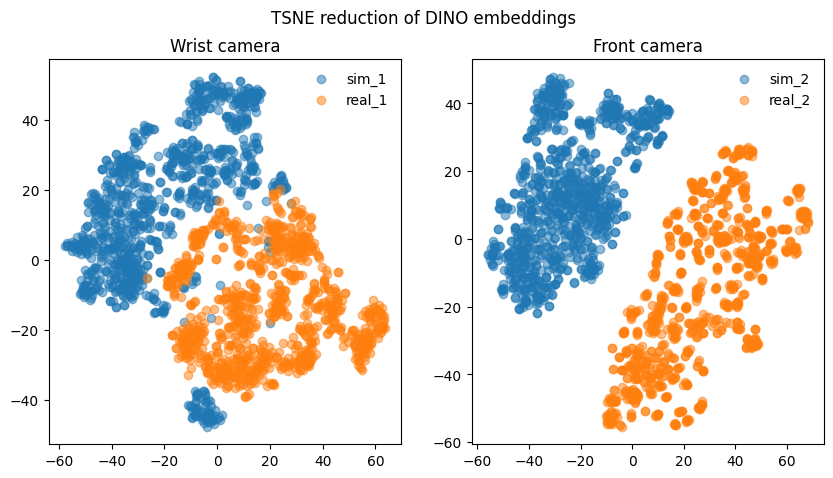

In [13]:
tsne = TSNE(n_components=2)
plot_latent_space(tsne, emb_sim_1, emb_sim_2, emb_real_1, emb_real_2)

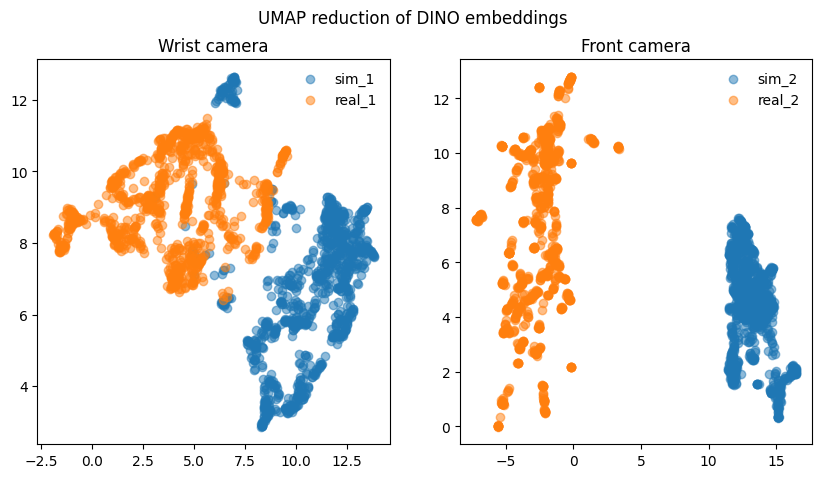

In [14]:
import umap

reducer = umap.UMAP()

plot_latent_space(reducer, emb_sim_1, emb_sim_2, emb_real_1, emb_real_2)

## Run some tests with Dino V1

In [2]:
vits16 = torch.hub.load("facebookresearch/dino:main", "dino_vits16")

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /data/scratch/ankile/.cache/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /data/scratch/ankile/.cache/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 112MB/s]


In [3]:
vits16

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [41]:
# Get random integers from 0 to 255
img = torch.randint(0, 255, (1, 224, 224, 3), dtype=torch.uint8)
img = img.permute(0, 3, 1, 2).float() / 255.0

vits16(img).shape

torch.Size([1, 384])

In [37]:
vits16.norm.normalized_shape

(384,)

In [42]:
# Get embeddings for a random sample of 1000 images
emb_sim_1 = get_embeddings(sample_n_rows(d_sim["color_image1"], 1000), vits16)
emb_sim_2 = get_embeddings(sample_n_rows(d_sim["color_image2"], 1000), vits16)
# emb_real_1 = get_embeddings(sample_n_rows(d_real["color_image1"], 1000), vits16)
# emb_real_2 = get_embeddings(sample_n_rows(d_real["color_image2"], 1000), vits16)

KeyboardInterrupt: 

In [ ]:
tsne = TSNE(n_components=2)
plot_latent_space(tsne, emb_sim_1, emb_sim_2, emb_real_1, emb_real_2)

In [1]:
import pickle


with open(
    "/data/scratch/ankile/furniture-data-old/data/raw/sim/image_small/one_leg/low/2023-10-25-17:49:38/2023-10-25-17:49:38.pkl",
    "rb",
) as f:
    data = pickle.load(f)

In [5]:
data.keys()

dict_keys(['observations', 'actions', 'rewards', 'skills', 'success', 'furniture', 'error', 'error_description'])